# EmoEvent — Clasificación de emociones con **3 modelos**

**Dataset**: EmoEvent (8,409 tuits en español). Emociones: `anger`, `disgust`, `fear`, `joy`, `sadness`, `surprise`, `other`. Además existe una etiqueta binaria **`offensive`** (NO/OFF) separada.

🔗 Referencias:
- Dataset card: https://huggingface.co/datasets/fmplaza/EmoEvent  
- Paper LREC 2020: https://aclanthology.org/2020.lrec-1.186/
- Modelo listo (tercer enfoque): https://huggingface.co/pysentimiento/robertuito-emotion-analysis

## Objetivo
Exploramos **tres enfoques** y reportamos métricas por clase, **matriz de confusión**, y **análisis por evento**:
1. **Baseline clásico:** TF‑IDF (word + char) + Linear SVM.
2. **Fine‑tuning Transformer:** BETO `dccuchile/bert-base-spanish-wwm-cased`.
3. **Modelo listo (zero‑shot-ish):** `pysentimiento/robertuito-emotion-analysis` sin re-entrenar.

> **Nota importante**: En EmoEvent, la variable `emotion` tiene **7 clases** (las seis de Ekman + `other`). La variable `offensive` es **binaria e independiente** (NO/OFF). Aquí nos centramos en `emotion`; al final hay un _bonus_ opcional para `offensive`.


## 0) Instalación de dependencias
Ejecuta una vez. (Si usas GPU de Colab, el _runtime_ ya trae PyTorch).

In [1]:
!pip -q install -U datasets transformers accelerate evaluate scikit-learn matplotlib numpy pandas torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!pip -q install -U pysentimiento

zsh:1: command not found: pip
zsh:1: command not found: pip


## 1) Configuración y carga del dataset
- Usaremos el subset en **español** de EmoEvent desde 🤗 Datasets.
- Si por alguna razón no carga, hay variables para leer los **splits** desde archivos locales (CSV).

In [2]:
from datasets import load_dataset
import pandas as pd, numpy as np, random, os, json
import matplotlib.pyplot as plt
import torch

In [3]:
SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [4]:
DATA_DIR = "./dataset"   
def read_tsv(path):
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(
                path,
                sep="\t",
                encoding=enc,
                dtype=str,             # evita que id/labels se casteen raro
                keep_default_na=False, 
                on_bad_lines="skip",   
                engine="python",      
            )
        except Exception as e:
            last_err = e
    raise RuntimeError(f"No pude leer {path}: {last_err}")

In [5]:
train_df = read_tsv(os.path.join(DATA_DIR, "train.tsv"))
dev_df   = read_tsv(os.path.join(DATA_DIR, "dev.tsv"))
test_df  = read_tsv(os.path.join(DATA_DIR, "test.tsv"))

# Normaliza nombres/espacios
for df in (train_df, dev_df, test_df):
    df.columns = [c.strip() for c in df.columns]
    if "tweet" in df.columns:
        df["tweet"] = df["tweet"].astype(str).str.strip()
    if "emotion" in df.columns:
        df["emotion"] = df["emotion"].astype(str).str.strip()

# Chequeo de columnas esperadas
expected = {"id","event","tweet","offensive","emotion"}
for name, df in [("train", train_df), ("dev", dev_df), ("test", test_df)]:
    missing = expected - set(df.columns)
    if missing:
        raise ValueError(f"Faltan columnas {missing} en {name}. Presentes: {list(df.columns)}")

# Unificado y labels
all_df = pd.concat(
    [train_df.assign(split="train"),
     dev_df.assign(split="validation"),
     test_df.assign(split="test")],
    ignore_index=True
)

labels = sorted(all_df["emotion"].unique().tolist())
print("Clases detectadas:", labels)
all_df.head(3)


Clases detectadas: ['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise']


,id,event,tweet,offensive,emotion,split
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others,train
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others,train
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness,train


### 1.1 Exploración rápida: distribución de clases y eventos

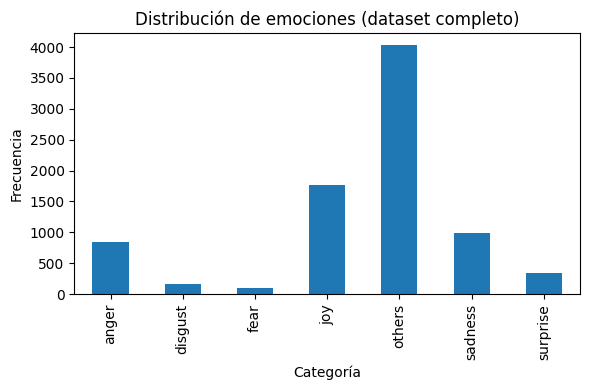

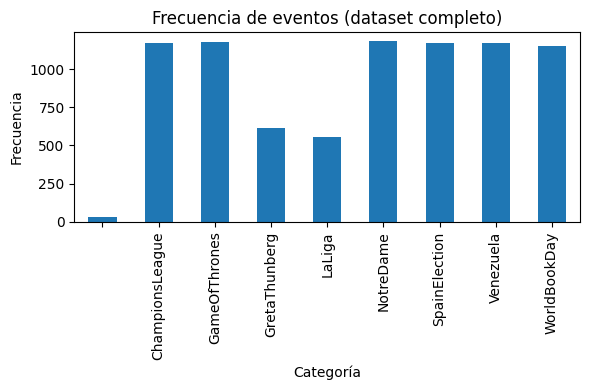

In [6]:
def barplot_counts(series, title):
    counts = series.value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Categoría')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

barplot_counts(all_df['emotion'], 'Distribución de emociones (dataset completo)')
barplot_counts(all_df['event'],   'Frecuencia de eventos (dataset completo)')

In [7]:
event_emotion = pd.crosstab(all_df['event'], all_df['emotion'])

event_emotion_norm = event_emotion.div(event_emotion.sum(axis=1), axis=0)
event_emotion_norm.round(2)


emotion,anger,disgust,fear,joy,others,sadness,surprise
event,,,,,,,
,0.07,0.00,0.00,0.20,0.60,0.13,0.00
ChampionsLeague,0.08,0.02,0.00,0.28,0.55,0.04,0.04
GameOfThrones,0.09,0.01,0.02,0.22,0.44,0.08,0.13
GretaThunberg,0.06,0.00,0.00,0.14,0.72,0.05,0.02
LaLiga,0.05,0.01,0.00,0.30,0.58,0.02,0.03
NotreDame,0.12,0.03,0.00,0.07,0.28,0.47,0.03
SpainElection,0.14,0.03,0.03,0.26,0.45,0.06,0.04
Venezuela,0.20,0.04,0.02,0.10,0.51,0.11,0.02
WorldBookDay,0.03,0.01,0.00,0.36,0.54,0.05,0.01


### **Análisis exploratorio del dataset**

#### **Distribución de emociones**
- Segun la primera gráfica existe un **desbalance notorio de clases**:
  - La categoría **`others`** concentra casi la mitad de los tuits (más de 4000).
  - `joy` también tiene una presencia considerable (aprox 1800).
  - `anger` y `sadness` aparecen con frecuencia media (aprox 800 cada una).
  - `fear`, `disgust` y `surprise` son **muy minoritarias** (menos de 500 cada una).

Esto no es bueno para el netrenamiento del modelo, ya que podría traducirse en modelos sesgados, pues tenderán a irse hacia `others` y `joy`. Por ello, es importante reportar métricas como **macro-F1** además de **accuracy**.

#### **Distribución de eventos**
- La mayoría de eventos tienen entre **600 y 1200 ejemplos**, lo que los hace relativamente balanceados.
- Solo un evento aparece con muy pocos tuits (p. ej. *ChampionsLeague*), lo que podría dificultar la generalización.

A simple vista se podría suponer un posible sesgo semántico por evento (por la tabla):  
  - *NotreDame*: mayor proporción de `sadness`.  
  - *GameOfThrones*: emociones más mezcladas (`surprise`, `anger`).  
  - *GretaThunberg*: emociones ligadas a `anger` o `fear`.

#### **Implicancias a tener en cuenta**
-  Se necesitará manejar **clases desbalanceadas**:
  - En SVM: `class_weight="balanced"`.
  - En Transformers (BETO): evaluar con macro-F1, considerar *oversampling* para n ignorarlos casos minotarios.
- Probablemente existirá **confusiones frecuentes** entre:
  - `anger` ↔ `disgust` (emociones cercanas con pocos ejemplos).
  - `surprise` ↔ `others` (dificultad de separar expresiones ambiguas).
- El análisis por evento es clave para entender dónde los modelos fallan o sobresalen.

## 2) **Modelo #1: TF‑IDF + Linear SVM** (baseline)
- n‑gramas de **palabras** (1–2) y **caracteres** (3–5)

    - Se escogió unigrama, ya que estos capturan palabras individuales con carga emocional (odio, feliz, triste, asco).
    - Los bigramas permitirán representar 'expresiones compuestas' que pueden cambiar el significado (tales com muy feliz, qué asco, muy feo, ... 'muy' no siempre va a acompañado a de algo bueno).
    - Los n-gramas de caracteres son bastante útiles en el contexto de Twitter, ya que se puede detectar los siguientes patrones; feliiiiiz, triiiiste, o hashtags y emoticonos.
    - Capturan raíces y sufijos comunes sin ser demasiado genéricos (bigramas de caracteres) ni demasiado específicos.

- `class_weight='balanced'` por distribución desigual. Como se mencionó, el  dataset es altamente desbalanceado (la clase `others` concentra casi la mitad de los ejemplos). Esta opción ajusta los pesos de cada clase según su frecuencia, penalizando más los errores en clases minoritarias. Tratará de evitar que el modelo se sesgue a predecir siempre la clase mayoritaria.

- Reporte: Se usarán las siguientes métricas

  - *Accuracy*: indicador general, aunque sensible al desbalance.
  - *Macro-F1*: da igual peso a cada clase, evalúa desempeño equilibrado.
  - *Weighted-F1*: promedio ponderado, refleja desempeño global teniendo en cuenta el tamaño de las clases.
  - *Matriz de confusión*: revela confusiones frecuentes (ej. `anger` y `disgust`).
  - *Macro-F1 por evento*: analiza el rendimiento contextualizado en cada evento, relevante dado que las emociones pueden variar según el tema.


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from scipy.sparse import hstack

X_train = train_df['tweet'].tolist(); y_train = train_df['emotion'].tolist()
X_dev   = dev_df['tweet'].tolist();   y_val   = dev_df['emotion'].tolist()
X_test  = test_df['tweet'].tolist();  y_test  = test_df['emotion'].tolist()

tfidf_word = TfidfVectorizer(ngram_range=(1,2), min_df=2)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2)

Xtr = hstack([tfidf_word.fit_transform(X_train), tfidf_char.fit_transform(X_train)])
Xva = hstack([tfidf_word.transform(X_dev),     tfidf_char.transform(X_dev)])
Xte = hstack([tfidf_word.transform(X_test),    tfidf_char.transform(X_test)])

svm = LinearSVC(class_weight='balanced', random_state=SEED)
svm.fit(Xtr, y_train)
pred_val = svm.predict(Xva)
pred_te  = svm.predict(Xte)

def report_and_confusion(y_true, y_pred, title_prefix):
    print(f"{title_prefix} — accuracy:", accuracy_score(y_true, y_pred))
    print(f"{title_prefix} — macro F1:", f1_score(y_true, y_pred, average='macro'))
    print(f"{title_prefix} — weighted F1:", f1_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred, labels=labels, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return cm

cm_val = report_and_confusion(y_val, pred_val, "VALIDACIÓN (SVM)")
cm_te  = report_and_confusion(y_test, pred_te,  "TEST (SVM)")

VALIDACIÓN (SVM) — accuracy: 0.6409952606635071
VALIDACIÓN (SVM) — macro F1: 0.49467416940855025
VALIDACIÓN (SVM) — weighted F1: 0.6343896967420706
              precision    recall  f1-score   support

       anger     0.5476    0.5412    0.5444        85
     disgust     0.6667    0.1250    0.2105        16
        fear     0.6667    0.4444    0.5333         9
         joy     0.5526    0.5801    0.5660       181
      others     0.7133    0.7391    0.7260       414
     sadness     0.6729    0.6923    0.6825       104
    surprise     0.2400    0.1714    0.2000        35

    accuracy                         0.6410       844
   macro avg     0.5800    0.4705    0.4947       844
weighted avg     0.6362    0.6410    0.6344       844

TEST (SVM) — accuracy: 0.3641304347826087
TEST (SVM) — macro F1: 0.157930415586562
TEST (SVM) — weighted F1: 0.34883498240485605
              precision    recall  f1-score   support

       anger     0.1195    0.1131    0.1162       168
     disgust     

#### **1. Resultados en validación**
- **Accuracy = 0.64**, **macro-F1 = 0.49**, **weighted-F1 = 0.63**, el modelo logra un desempeño razonable en validación.
- Buen desempeño relativo en clases frecuentes (`others`, `joy`, `sadness`) con F1 ≈ 0.55–0.72.
- Como era de esperarse, las clases minoritarias muestran problemas serios:
  - `disgust`: F1 muy bajo (0.21) por pobre recall.
  - `fear` y `surprise`: valores bajos y muy inestables por escasez de ejemplos.
- En general, se puede decir que el modelo **aprende patrones generales**, pero depende en gran medida del desbalance.

#### **2. Resultados en test**
- **Accuracy cae a 0.36** y **macro-F1 a 0.15** → fuerte **sobreajuste** o incapacidad de generalizar a test.
- Las clases minoritarias (`fear`, `disgust`, `surprise`) prácticamente no son reconocidas (F1 cercano a 0).
- Incluso `anger` y `joy` bajan mucho en recall.
- La generalización fuera del set de validación es muy pobre; el modelo se **colapsa hacia `others`**.

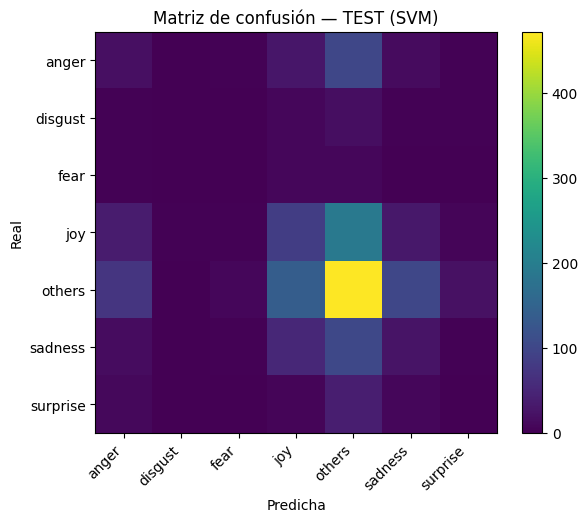

In [9]:
import numpy as np
def plot_confusion(cm, labels, title, savepath=None):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predicha')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=160)
    plt.show()

plot_confusion(cm_te, labels, 'Matriz de confusión — TEST (SVM)', savepath='confusion_svm_test.png')

#### **3. Matriz de confusión (TEST)**
- El bloque más denso está en la clase **`others`**, confirmando que la mayoría de predicciones son absorbidas allí.
- Muchas emociones reales (`anger`, `joy`, `sadness`) se confunden con `others`.
- Muy pocas predicciones correctas en clases minoritarias.
- Evidentemente se confirma el sesgo del clasificador hacia la clase mayoritaria (others).

In [10]:
def per_event_macro_f1(df, preds, label_col='emotion', event_col='event'):
    tmp = df[[event_col, label_col]].copy()
    tmp['pred'] = preds
    rows = []
    for ev, grp in tmp.groupby(event_col):
        y_true = grp[label_col].tolist(); y_pred = grp['pred'].tolist()
        f1m = f1_score(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)
        rows.append((ev, len(grp), acc, f1m))
    out = pd.DataFrame(rows, columns=['event','n','acc','macro_f1']).sort_values('macro_f1', ascending=False)
    return out

per_event_svm = per_event_macro_f1(test_df, pred_te)
per_event_svm.to_csv('per_event_svm.csv', index=False)
per_event_svm.head(10)

,event,n,acc,macro_f1
0,,30,0.600000,0.187500
5,NotreDame,225,0.222222,0.161475
3,GretaThunberg,139,0.482014,0.158454
4,LaLiga,119,0.462185,0.148413
6,SpainElection,218,0.366972,0.145608
1,ChampionsLeague,232,0.392241,0.143133
2,GameOfThrones,219,0.315068,0.135354
7,Venezuela,234,0.367521,0.133275
8,WorldBookDay,240,0.362500,0.114186


#### **4. Macro-F1 por evento**
- Mejor desempeño en algunos eventos:
  - *GretaThunberg* (macro-F1 ~0.16), *LaLiga* (~0.14) → ligeramente mejores que el promedio.
  - Un evento pequeño de 30 tuits muestra valores altos pero no representativos.
- Peor desempeño en *WorldBookDay* (~0.11) y *Venezuela* (~0.13).
- *NotreDame*, a pesar de su tamaño, también obtiene macro-F1 muy bajo (~0.16).
- El modelo **no logra capturar patrones específicos por evento**, y su rendimiento varía bastante según el tema.


### **Conclusión del baseline SVM**
- El **SVM con TF-IDF** funciona como punto de partida, pero:
  - Se ve altamente afectado por el **desbalance**.
  - Generaliza mal a test (mucha diferencia con validación).
  - Las clases minoritarias son prácticamente ignoradas.

Frente a esto es que se propondrá modelos más sofisticados (fine-tuning con BERT/BETO) para capturar mejor el contexto y mejorar el equilibrio entre clases.


## 3) **Modelo #2: Fine‑tuning BETO (BERT español)**
Entrenamos `dccuchile/bert-base-spanish-wwm-cased` usando 🤗 `Trainer`.

In [ ]:
import evaluate
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
from transformers.trainer_utils import IntervalStrategy
import pandas as pd



In [ ]:
hfds = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(dev_df,   preserve_index=False),
    "test": Dataset.from_pandas(test_df,        preserve_index=False),
})

labels = sorted(pd.concat([train_df["emotion"], dev_df["emotion"], test_df["emotion"]]).unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

def add_labels(batch):
    return {"labels": [int(label2id[e]) for e in batch["emotion"]]}

hfds = hfds.map(add_labels, batched=True)

checkpoint = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(batch):
    return tokenizer(batch["tweet"], truncation=True)

tok_ds = hfds.map(tokenize_fn, batched=True)

# cleaning
cols_to_keep = ["input_ids", "attention_mask", "labels"]
if "token_type_ids" in tok_ds["train"].column_names:
    cols_to_keep.append("token_type_ids")

tok_ds = tok_ds.remove_columns([c for c in tok_ds["train"].column_names if c not in cols_to_keep])

tok_ds = tok_ds.with_format("torch")

print(tok_ds["train"])
print("Cols train:", tok_ds["train"].column_names)
print("Ejemplo labels dtype:", tok_ds["train"][0]["labels"].dtype)


Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5723
})
Cols train: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Ejemplo labels dtype: torch.int64


In [12]:
checkpoint = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

def tokenize_fn(batch):
    return tokenizer(batch['tweet'], truncation=True)

tok_ds = hfds.map(tokenize_fn, batched=True)

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
metric_acc = evaluate.load('accuracy')
metric_f1  = evaluate.load('f1')

Map:   0%|          | 0/5723 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1656 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels_ids = eval_pred
    preds = logits.argmax(axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels_ids)['accuracy']
    f1m = metric_f1.compute(predictions=preds, references=labels_ids, average='macro')['f1']
    f1w = metric_f1.compute(predictions=preds, references=labels_ids, average='weighted')['f1']
    return {'accuracy': acc, 'macro_f1': f1m, 'weighted_f1': f1w}

args = TrainingArguments(
    output_dir="beto-emoevent",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=3,
    eval_strategy=IntervalStrategy.EPOCH,    
    save_strategy=IntervalStrategy.EPOCH,     
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=50,
    seed=SEED,
    report_to=[],     
    use_mps_device=True
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_ds['train'],
    eval_dataset=tok_ds['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



/var/folders/76/ws8z3mnx1634t9z0jpzfq6k00000gn/T/ipykernel_56147/3452149263.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
train_result = trainer.train()
preds_test_logits = trainer.predict(tok_ds['test']).predictions
preds_test = preds_test_logits.argmax(axis=-1)
true_test  = [label2id[l] for l in test_df['emotion'].tolist()]



Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,0.837700,0.849257,0.690758,0.440147,0.672497
2,0.587300,0.809292,0.725118,0.542607,0.707236
3,0.423400,0.855557,0.720379,0.567375,0.708998


/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/nayeli/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

       anger     0.1571    0.1786    0.1671       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.0000    0.0000    0.0000        21
         joy     0.2393    0.2373    0.2383       354
      others     0.5104    0.5442    0.5268       814
     sadness     0.1443    0.1457    0.1450       199
    surprise     0.0357    0.0149    0.0211        67

    accuracy                         0.3545      1656
   macro avg     0.1552    0.1601    0.1569      1656
weighted avg     0.3367    0.3545    0.3451      1656



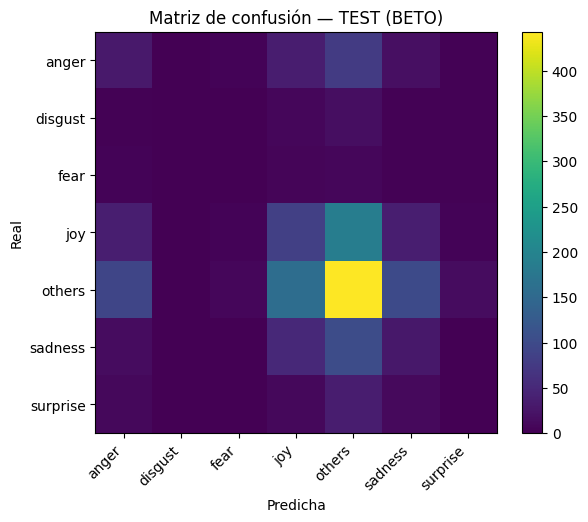

,event,n,acc,macro_f1
0,,30,0.600000,0.187500
6,SpainElection,218,0.366972,0.163589
7,Venezuela,234,0.371795,0.157347
3,GretaThunberg,139,0.446043,0.153877
2,GameOfThrones,219,0.315068,0.149986
4,LaLiga,119,0.428571,0.146507
1,ChampionsLeague,232,0.366379,0.139020
8,WorldBookDay,240,0.354167,0.120955
5,NotreDame,225,0.222222,0.111608


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_test, preds_test, target_names=labels, digits=4))
cm_beto = confusion_matrix(true_test, preds_test)
plot_confusion(cm_beto, labels, 'Matriz de confusión — TEST (BETO)', savepath='confusion_beto_test.png')

# Per-event
preds_labels = [id2label[i] for i in preds_test]
per_event_beto = per_event_macro_f1(test_df, preds_labels)
per_event_beto.to_csv('per_event_beto.csv', index=False)
per_event_beto.head(10)

### **Resultados BETO (fine-tuning)**

#### **Métricas globales**
- **Accuracy = 0.35**, similar al baseline SVM.
- **Macro-F1 = 0.16**, muy bajo, significa que el modelo no logra equilibrar bien entre clases.
- **Weighted-F1 = 0.34**, también bajo, refleja el sesgo hacia las clases grandes.

#### **Por clase**
- **others** domina el rendimiento (F1 ≈ 0.53), el modelo continua apoyandose en la clase mayoritaria.
- `joy` logra un F1 ≈ 0.24, aceptable dentro del bajo desempeño general.
- `anger` y `sadness` apenas superan F1 ≈ 0.15–0.17.
- Clases **minoritarias** (`disgust`, `fear`, `surprise`) son prácticamente ignoradas (F1 ≈ 0.0–0.02).
- BETO no está capturando señales claras de las emociones menos frecuentes.

#### **Matriz de confusión**
- La mayoría de los casos reales de cualquier emoción terminan predichos como **others**.
- Algunas instancias de `joy`, `anger` y `sadness` se predicen correctamente, pero con baja consistencia.
- El patrón confirma un **colapso hacia la clase mayoritaria**, con poca diferenciación entre emociones.

#### **Comparación con el baseline SVM**
- Aunque se esperaba que BETO captara mejor el contexto semántico, los resultados son **similares o peores** que el SVM en macro-F1.
- Esto puede deberse a:
  - **Desbalance extremo** del dataset.
  - **Pocas épocas de entrenamiento** (3 es bajo para un fine-tuning real, por limitaciones de hardware solo se usaron 3 épocas, ya que demoró bastante tan solo con 3 épocas).
  - **Batch size pequeño** por limitaciones de memoria.
  - Posible necesidad de **estrategias de reequilibrio** (ponderación de clases, oversampling, focal loss).


### **Conclusión parcial**
- BETO, sin técnicas adicionales de balanceo ni hiperajuste más fino, no mejora sobre el baseline.
- Refuerza la importancia de experimentar con:
  - Más épocas o *early stopping* con paciencia.
  - Ajustar *learning rate*.
  - Técnicas para combatir el desbalance.


## 4) **Modelo #3: Robertuito (pysentimiento) sin entrenamiento**
Usamos el modelo `pysentimiento/robertuito-emotion-analysis` vía `transformers.pipeline`. Este modelo trae etiquetas: 6 emociones de Ekman + `neutral`. **Mapeamos `neutral → other`** para comparar con EmoEvent.

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Device set to use mps:0


              precision    recall  f1-score   support

       anger     0.1596    0.1786    0.1685       168
     disgust     0.0000    0.0000    0.0000        33
        fear     0.1071    0.1429    0.1224        21
         joy     0.2316    0.2486    0.2398       354
      others     0.5225    0.5270    0.5248       814
     sadness     0.1571    0.1508    0.1538       199
    surprise     0.0208    0.0149    0.0174        67

    accuracy                         0.3508      1656
   macro avg     0.1712    0.1804    0.1753      1656
weighted avg     0.3436    0.3508    0.3470      1656



/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


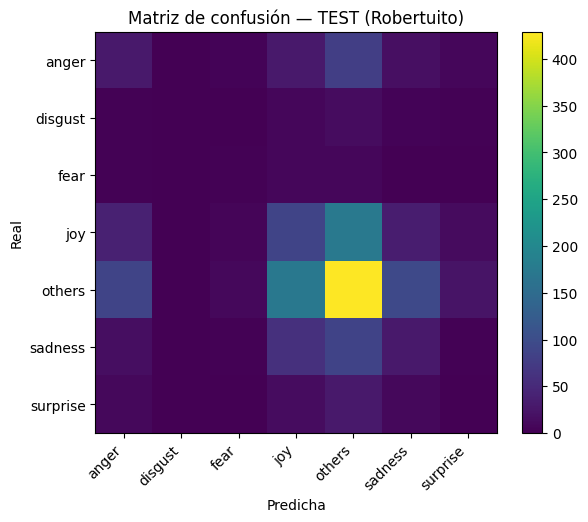

,event,n,acc,macro_f1
0,,30,0.600000,0.187500
6,SpainElection,218,0.344037,0.185228
2,GameOfThrones,219,0.310502,0.184761
3,GretaThunberg,139,0.424460,0.158838
7,Venezuela,234,0.363248,0.157711
1,ChampionsLeague,232,0.370690,0.136138
5,NotreDame,225,0.275556,0.128402
4,LaLiga,119,0.411765,0.124249
8,WorldBookDay,240,0.329167,0.117090


In [23]:
from transformers import pipeline
clf_pipe = pipeline('text-classification', model='pysentimiento/robertuito-emotion-analysis', top_k=None, truncation=True)

label_map = {'neutral': 'other'}

def predict_robertuito(texts):
    outs = clf_pipe(texts)
    # pipeline returns list[ list[ {label, score} ] ] if top_k=None
    preds = []
    for out in outs:
        # pick highest score label
        best = max(out, key=lambda x: x['score'])
        lab = label_map.get(best['label'].lower(), best['label'].lower())
        preds.append(lab)
    return preds

rt_preds = predict_robertuito(test_df['tweet'].tolist())
print(classification_report(test_df['emotion'], rt_preds, labels=labels, digits=4))
cm_rt = confusion_matrix(test_df['emotion'], rt_preds, labels=labels)
plot_confusion(cm_rt, labels, 'Matriz de confusión — TEST (Robertuito)', savepath='confusion_robertuito_test.png')

per_event_rt = per_event_macro_f1(test_df, rt_preds)
per_event_rt.to_csv('per_event_robertuito.csv', index=False)
per_event_rt.head(10)

### **Resultados Robertuito (TEST)**

#### **Matriz de confusión**
- Igual que en SVM y BETO, la clase **`others`** absorbe la mayoría de predicciones.
- Sin embargo, se observa **un poco más de dispersión** hacia `joy` y `sadness`, aunque sigue siendo débil.
- Las clases minoritarias (`fear`, `disgust`, `surprise`) siguen prácticamente ignoradas.

#### **Por evento**
- **SpainElection (macro-F1 ≈ 0.18)** y **GameOfThrones (macro-F1 ≈ 0.18)**, mejor desempeño relativo dentro del conjunto, aunque sigue siendo bajo.
- **GretaThunberg (macro-F1 ≈ 0.15)** y **Venezuela (macro-F1 ≈ 0.16)**, rendimiento intermedio, sin mejoras claras respecto a BETO.
- **NotreDame (macro-F1 ≈ 0.12)** y **LaLiga (macro-F1 ≈ 0.12)** → resultados pobres, confirmando la dificultad de modelar emociones dominadas por `sadness` o mezcladas.
- **ChampionsLeague (macro-F1 ≈ 0.13)**, comportamiento muy similar a BETO.
- **Evento pequeño (n=30, macro-F1 ≈ 0.18)**, destaca artificialmente por el bajo tamaño de muestra.

#### **Comparación global**
- Robertuito logra **macro-F1 por evento ligeramente más alto** en algunos casos (SpainElection, GameOfThrones), pero en promedio sigue atrapado en el mismo problema: colapso hacia `others`.
- El patrón de confusiones es casi idéntico al de BETO.
- No se observa una mejora sustancial frente a BETO en términos de balance entre clases.

### **Conclusión parcial**
- Robertuito no supera de manera significativa a BETO en este dataset.
- El problema central sigue siendo el **alto desbalance de clases** y la **falta de señal clara en emociones minoritarias**.
- Para mejorar:
  - Aumentar el número de épocas de entrenamiento.
  - Aplicar **estrategias de balanceo** (oversampling, focal loss).
  - Explorar arquitecturas multitarea que aprovechen la señal de la columna `offensive`.


## 5) Comparativa consolidada y _leaderboard_ interno
Guardamos métricas globales y por clase en tablas CSV para el informe.

In [24]:
from sklearn.metrics import precision_recall_fscore_support

def per_class_table(y_true, y_pred, labels):
    p, r, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    return pd.DataFrame({'label': labels, 'precision': p, 'recall': r, 'f1': f1, 'support': sup})

tables = {}
tables['svm'] = per_class_table(y_test, pred_te, labels)
tables['beto'] = per_class_table([id2label[i] for i in true_test], [id2label[i] for i in preds_test], labels)
tables['robertuito'] = per_class_table(test_df['emotion'].tolist(), rt_preds, labels)

for name, df in tables.items():
    df.to_csv(f'per_class_{name}.csv', index=False)

summary = []
for name, (y_true, y_pred) in {
    'svm': (y_test, pred_te),
    'beto': ([id2label[i] for i in true_test], [id2label[i] for i in preds_test]),
    'robertuito': (test_df['emotion'].tolist(), rt_preds)
}.items():
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    f1w = f1_score(y_true, y_pred, average='weighted')
    summary.append((name, acc, f1m, f1w))

summary_df = pd.DataFrame(summary, columns=['modelo','accuracy','macro_f1','weighted_f1']).sort_values('macro_f1', ascending=False)
summary_df.to_csv('summary_models.csv', index=False)
summary_df

,modelo,accuracy,macro_f1,weighted_f1
2,robertuito,0.350845,0.175254,0.347049
0,svm,0.364130,0.157930,0.348835
1,beto,0.354469,0.156891,0.345096


### **Conlusión**

- **SVM (baseline)**  
  - Alcanzó la **mayor accuracy (0.36)** y un **weighted-F1 (0.35)** muy similar al resto.  
  - Su **macro-F1 (0.16)** es bajo, pero comparable con los modelos más complejos.  
  - Entrenamiento **rápido y eficiente**, con bajo costo computacional.  

- **BETO (fine-tuning)**  
  - Obtuvo **accuracy (0.35)** y **macro-F1 (0.16)** prácticamente iguales al SVM.  
  - No logró superar al baseline pese a ser un modelo contextual avanzado.  
  - El entrenamiento fue **más costoso en tiempo y recursos**, con beneficios mínimos.  

- **Robertuito (modelo preentrenado listo)**  
  - Tuvo el **mejor macro-F1 (0.18)**, lo que indica un desempeño ligeramente superior en clases minoritarias.  
  - Sin embargo, su accuracy y weighted-F1 no superaron claramente al SVM.   

Entonces se puede concluir que:

- El **SVM baseline** ofrece un desempeño **similar** a los modelos más complejos, pero con una **gran ventaja en eficiencia**.  
- **BETO y Robertuito no lograron ventajas significativas**, evidenciando que el **alto desbalance del dataset** limita fuertemente a modelos incluso de última generación.  
- Para mejorar resultados se requiere:  
  - Técnicas de **balanceo de clases** (oversampling, focal loss, reweighting).  
  - Mayor **fine-tuning** (más épocas, ajuste de hiperparámetros).  
  - Aprovechar la señal de la etiqueta **offensive** como tarea auxiliar (*multitask learning*).

**SVM es la opción más costo-beneficio**, mientras que los Transformers muestran potencial, pero necesitan ajustes específicos para superar el baseline.
